In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [13]:
Nat_Gas = os.path.join(os.path.expanduser("~"), "Desktop", "Natural_Gas_monthly.csv")
df = pd.read_csv(Nat_Gas)
df = df.set_index('Month')


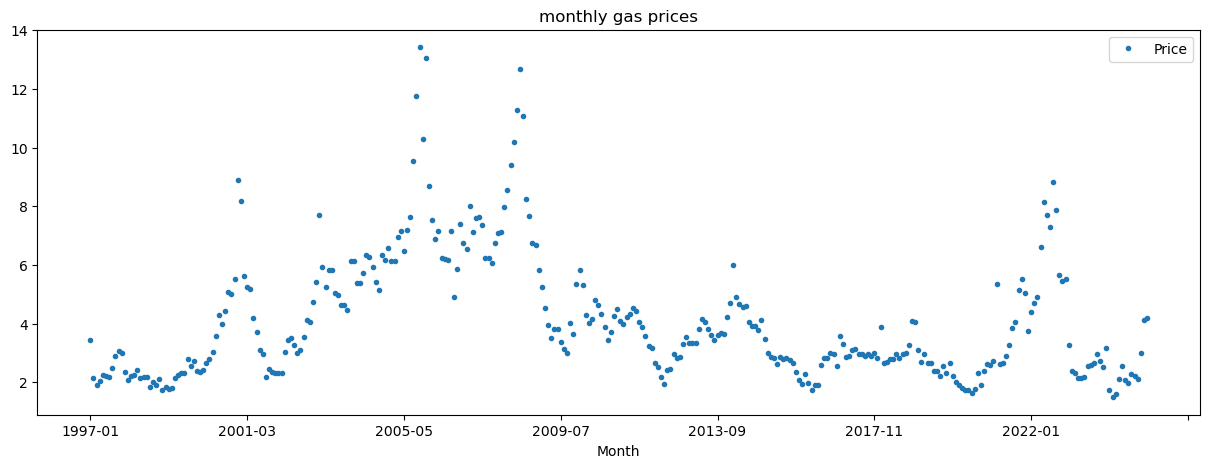

In [14]:
 df.plot(style='.',
        figsize=(15, 5),
        title='monthly gas prices')
plt.show()

In [15]:
df.index = pd.to_datetime(df.index)
df.dtypes

Price    float64
dtype: object

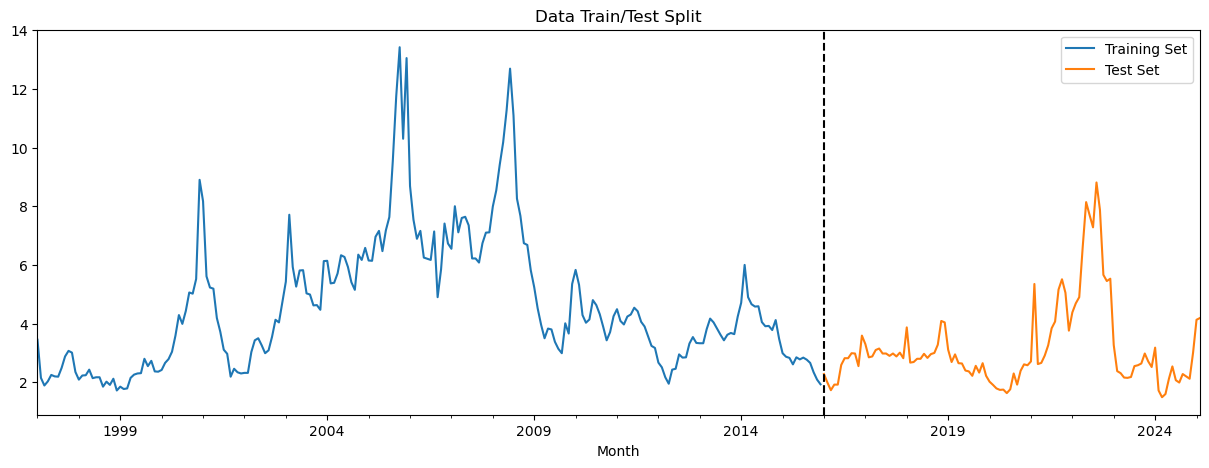

In [16]:
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [17]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df.head()

,Price,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Month,,,,,,,,
1997-01-01,3.45,2,1,1,1997,1,1,1
1997-02-01,2.15,5,1,2,1997,32,1,5
1997-03-01,1.89,5,1,3,1997,60,1,9
1997-04-01,2.03,1,2,4,1997,91,1,14
1997-05-01,2.25,3,2,5,1997,121,1,18


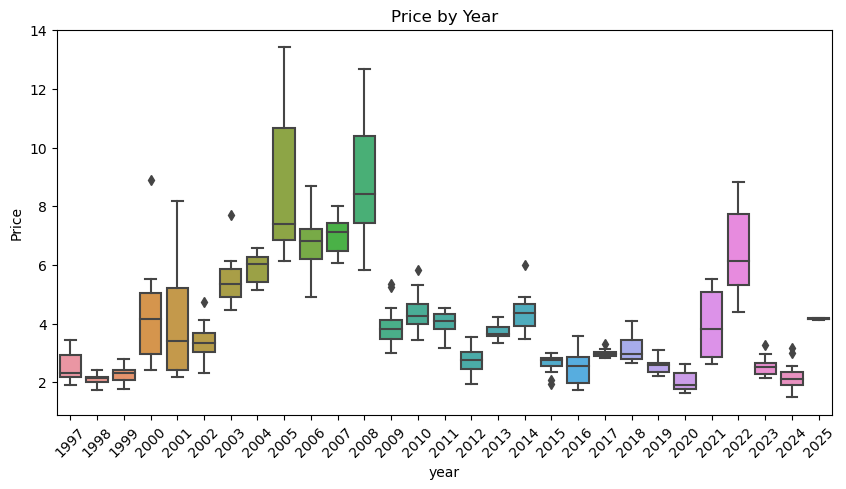

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x='year', y='Price')
ax.set_title('Price by Year')
plt.xticks(rotation=45)
plt.show()

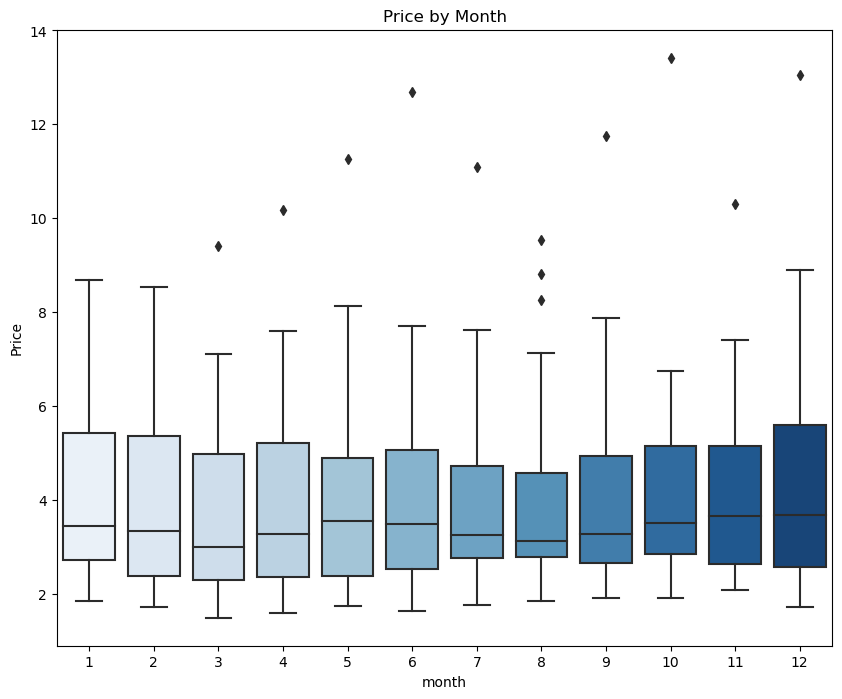

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Price', palette='Blues')
ax.set_title('Price by Month')
plt.show()

In [20]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [21]:
X_test.head()

,dayofyear,dayofweek,quarter,month,year
Month,,,,,
2016-01-01,1,4,1,1,2016
2016-02-01,32,0,1,2,2016
2016-03-01,61,1,1,3,2016
2016-04-01,92,4,2,4,2016
2016-05-01,122,6,2,5,2016


In [22]:
y_test.head()

Month
2016-01-01    2.28
2016-02-01    1.99
2016-03-01    1.73
2016-04-01    1.92
2016-05-01    1.92
Name: Price, dtype: float64

In [23]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

# Initialize XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE on test set:", rmse)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Best score: -4.62690728975386
RMSE on test set: 1.576096339547687


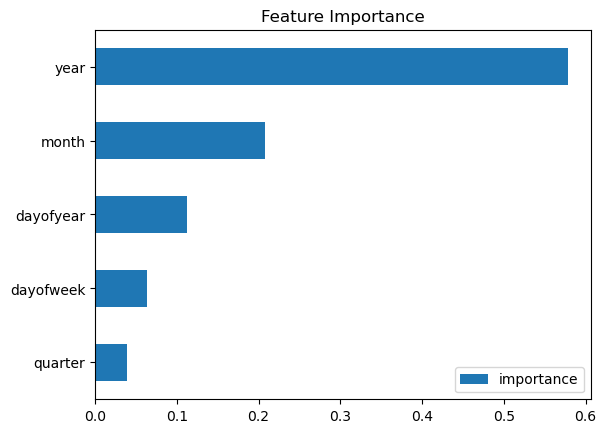

In [24]:
fi = pd.DataFrame(data=best_model.feature_importances_,
             index=best_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

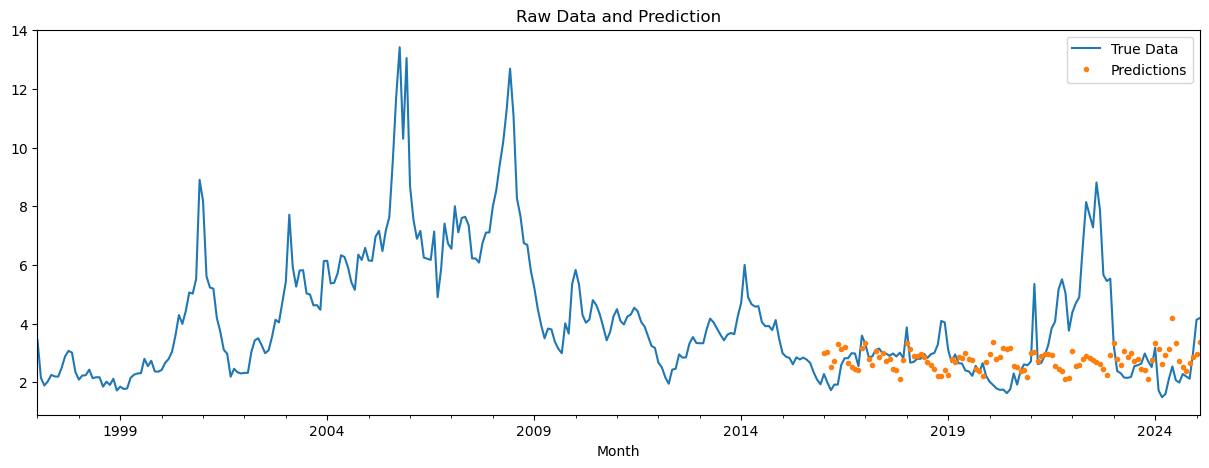

In [25]:
#Forecast on Test set
test['prediction'] = best_model.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Price']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [26]:
score = np.sqrt(mean_squared_error(test['Price'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')


RMSE Score on Test set: 1.58
